<a href="https://colab.research.google.com/github/montyharr/montyharr-learning-ml/blob/master/monty_ml_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Monty Harr 3.
## Google Colab Classification
Flick thru:
 - Numbers
 - graphs
 -accuracy

Questions: 
 - Classify MNIST data 97%
 - Modify data and train again
 - Titanic dataset Kaggle
 - Spam classifier. (big)


#Setup

In [1]:
# Python >= 3.5 is required
import sys
assert sys.version_info >=(3,5)

# Scikit-Learn >= 0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID =  "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
  path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
  print("Saving figure", fig_id)
  if tight_layout:
    plt.tight_layout()
  plt.savefig(path, format = fig_extension, dpi = resolution)

#MNIST

In [ ]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

In [ ]:
X,y = mnist["data"], mnist["target"]
X.shape

In [ ]:
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28) # reshaping 
plt.imshow(some_digit_image, cmap = mpl.cm.binary)
plt.axis("off")

save_fig("some_digit_plot")
plt.show()

In [ ]:
y[0] #label tells us this is in fact a 5

label is a string, most ML expect numbers, so let's cast y to integer

In [ ]:
y = y.astype(np.uint8)

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

#Binary Classifier

**Note**: some hyperparameters will have a different defaut value in future versions of Scikit-Learn, such as `max_iter` and `tol`. To be future-proof, we explicitly set these hyperparameters to their future default values. For simplicity, this is not shown in the book.

In [ ]:
y_train_5 = (y_train == 5) # True for all 5s
y_test_5 = (y_test == 5)

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter = 1000, tol = 1e-3, random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
#pass our newly trained classifier our "some digit" variable and see what it thinks.
sgd_clf.predict([some_digit])

array([ True])

In [ ]:
#Hooray it thinks we've got a 5 on our hands!
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring = "accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
  clone_clf = clone(sgd_clf)
  X_train_folds = X_train[train_index]
  y_train_folds = y_train_5[train_index]
  X_test_fold = X_train[test_index]
  y_test_fold = y_train_5[test_index]

  clone_clf.fit(X_train_folds, y_train_folds)
  y_pred = clone_clf.predict(X_test_fold)
  n_correct = sum(y_pred == y_test_fold)
  print(n_correct/len(y_pred))

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_split.py:296: FutureWarning: Setting a random_state has no effect since shuffle is False. This will raise an error in 0.24. You should leave random_state to its default (None), or set shuffle=True.
  FutureWarning


0.95035
0.96035
0.9604


In [ ]:
#how bad is it REALLY!?
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
  def fit(self, X,y=None):
    return self
  def predict(self, X):
    return np.zeros((len(X),1), dtype=bool)

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [ ]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [ ]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [ ]:
y_train_perfect_predictions = y_train_5 # pretend we reached perfection
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

In [ ]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [ ]:
4096/(4096+(1522+1352)/2)

0.7402855593710465

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [ ]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [ ]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [ ]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3,
                             method = "decision_function")

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Saving figure precision_recall_vs_threshold_plot


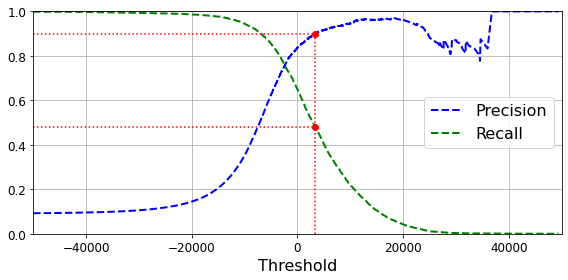

In [ ]:
#Use matplotlib to plot precision and recall as functions of the threshold value

def plot_precision_reall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label = "Precision", linewidth=2)
  plt.plot(thresholds, recalls[:-1], "g--",label="Recall", linewidth=2)
  plt.legend(loc="center right", fontsize=16)
  plt.xlabel("Threshold", fontsize=16)
  plt.grid(True)
  plt.axis([-50000,50000,0,1])

recall_90_precision = recalls[np.argmax(precisions>= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

plt.figure(figsize=(8,4))
plot_precision_reall_vs_threshold(precisions, recalls,thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")  
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro")                             # Not shown
save_fig("precision_recall_vs_threshold_plot")                                              # Not shown
plt.show()

In [ ]:
(y_train_pred == (y_scores >0)).all()

True

Saving figure precision_vs_recall_plot


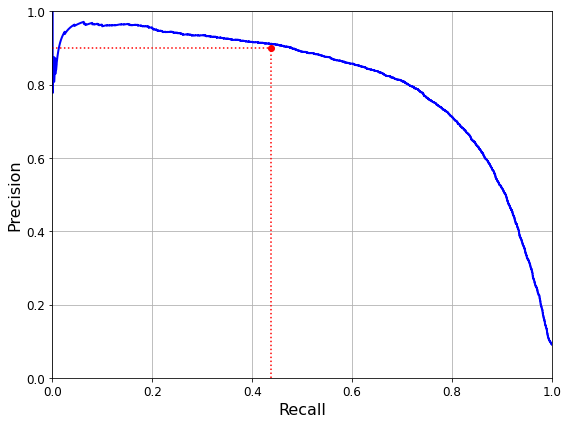

In [ ]:
def plot_precision_vs_recall(precisions, recalls):
  plt.plot(recalls, precisions, "b-", linewidth=2)
  plt.xlabel("Recall", fontsize = 16)
  plt.ylabel("Precision", fontsize=16)
  plt.axis([0,1,0,1])
  plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([0.4368, 0.4368], [0., 0.9], "r:")
plt.plot([0.0, 0.4368], [0.9, 0.9], "r:")
plt.plot([0.4368], [0.9], "ro")
save_fig("precision_vs_recall_plot")
plt.show()


In [ ]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]

In [ ]:
threshold_90_precision

3370.0194991439557

In [ ]:
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [ ]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [ ]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

# ROC curves

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Saving figure roc_curve_plot


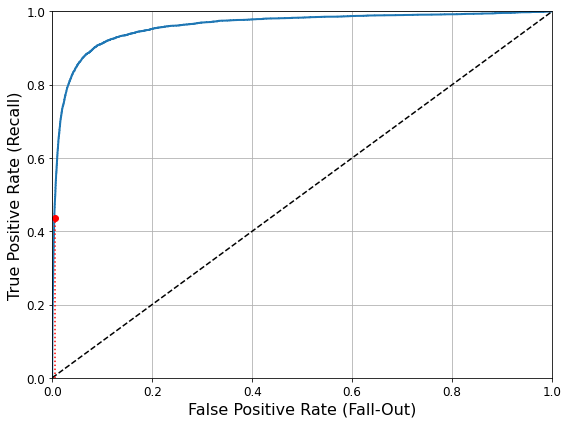

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
  plt.plot(fpr, tpr, linewidth=2, label=label)
  plt.plot([0,1],[0,1], 'k--') # dashed diagonal
  plt.axis([0,1,0,1])
  plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16)
  plt.ylabel('True Positive Rate (Recall)', fontsize=16)
  plt.grid(True)

plt.figure(figsize=(8,6))
plot_roc_curve(fpr,tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
save_fig("roc_curve_plot")                         # Not shown
plt.show()

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [ ]:
#Note n_estimators = 100 to be future-prood since this will be the default value
# in scikit learn 0.22

from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method = "predict_proba")

In [ ]:
y_scores_forest = y_probas_forest[:,1] #score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)


Saving figure roc_curve_comparison_plot


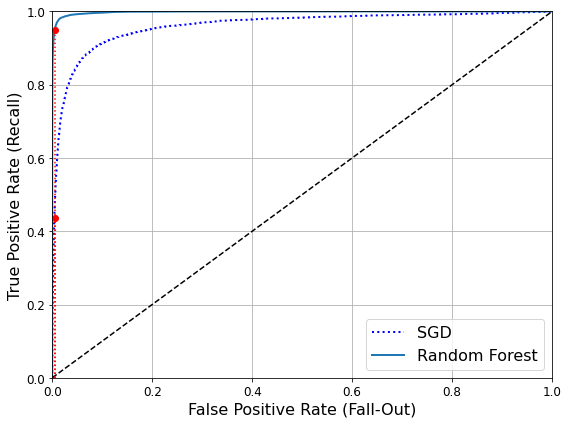

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
save_fig("roc_curve_comparison_plot")
plt.show()

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [ ]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9905083315756169

In [ ]:
recall_score(y_train_5, y_train_pred_forest)

0.8662608374838591

In [ ]:
y_train_5

array([ True, False, False, ...,  True, False, False])

#Multiclass classification

In [ ]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()

X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

grid_params = {
    'n_neighbors':[3,5,11,19],
    'weights':['uniform','distance']
}

gs = GridSearchCV(
    KNeighborsClassifier(),
    grid_params,
    verbose = 1,
    cv = 3,
    n_jobs = -1
)

gs_results = gs.fit(X_train_scaled, y_train)